In [3]:
import numpy as np
from scipy.integrate import solve_ivp, quad
from scipy.interpolate import UnivariateSpline

from scipy import constants as cons

from matplotlib import pyplot as plt
from matplotlib import rc

import matplotlib.animation as animation

In [30]:
class LongRing:
    Cgamma = 9.846e-5 # m/eV3
    _defaults_ = {
        "freq": 400e6, # RF frequency [V]
        "Erest": cons.m_e*cons.c**2/cons.e, # energy at rest [eV]
        "alpha": 7.32686686e-6*2, # momentum compaction factor
        "length": 91174.1174166,  # circumfrence [m]
        "I2": 0.00060404 , # second synchrotron radiation integral
        "I6": 0,
        "Egain": 0. # energy gain
        }
    def __init__(self, Vtot, Etot, **kw):
        kw_loc = dict(LongRing._defaults_)
        kw_loc.update(kw)
        for key, val in kw_loc.items():
            setattr(self, key, val)
        self.set_ener(Etot)
        self.set_freq()
        self.set_alpha()
        self.set_volt(Vtot=Vtot)
               
    def set_alpha(self, alpha=None):
        if alpha is not None:
            self.alpha = alpha
        self.gammat = 1/np.sqrt(self.alpha) # transition energy
        self.eta = 1/self.gamma**2-self.alpha # momentum compaction

    def set_freq(self, freq=None):
        if freq is not None:
            self.freq = freq
        self.lambdaRF = cons.c/self.freq # RF wavelength

    def set_ener(self, Etot=None, Erest=None, I2=None):
        if Erest is not None:
            self.Erest = Erest
        if I2 is not None:
            self.I2 = I2        
        if Etot is not None:
            self.Etot = Etot
        self.gamma = self.Etot/self.Erest
        self.beta = np.sqrt(1-1/self.gamma**2) # normalized velocity
        self.U0 = LongRing.Cgamma*(self.Etot*1e-9)**4/2/np.pi*self.I2*1e9 # Synchrotron energy loss per turn
        self.eta = 1/self.gamma**2-self.alpha # slippage factor or momentum compaction
        
    def set_volt(self, Vtot=None, phis=None, Egain=None):
        if Vtot is not None:
            self.Vtot = Vtot # total voltage
        if Egain is not None:
            self.Egain = Egain # energy gain
        if phis is None:
            self.phis = np.arcsin((self.Egain+self.U0)/self.Vtot) # synchronus phase - not delta(E)/e*V ?
            if self.gamma > self.gammat:
                self.phis = np.pi-self.phis
        else:
            self.phis = phis
            self.Egain = self.Vtot*self.phis-self.U0
        self.gradient = self.Vtot/self.length # accelerating gradient
        fac = 2*self.beta**3*self.Etot*self.lambdaRF/np.pi/self.eta
        self.dEmax = np.sqrt((np.cos(self.phis)-(np.pi/2-self.phis)*np.sin(self.phis))*fac*self.gradient)
        self.dpmax = self.dEmax/self.Etot
        self.Qs = self.length/np.pi*np.sqrt(self.gradient/fac*np.cos(self.phis)) # synchrotron tune
            
    def sigz(self, dpmax): # bunch length
        return np.sqrt(2*np.pi*self.eta/self.lambdaRF/self.beta**3/self.gradient/np.cos(self.phis)*dpmax**2*self.Etot)

In [90]:
injDRing_400 = LongRing(Etot=45.6e9, Vtot=100e6, freq=400e6)

In [96]:
injDRing_400.sigz(0.1)

7.481759974911272

In [196]:
injDRing_400 = LongRing(Etot=45.6e9, Vtot=100e6, freq=400e6)
injDRing_800 = LongRing(Etot=45.6e9, Vtot=100e6, freq=800e6)

voltage = np.linspace(50e6, 200e6, 101)
tab_Qs_400 = np.zeros_like(voltage)
tab_dpmax_400 = np.zeros_like(voltage)
tab_phis_400 = np.zeros_like(voltage)
tab_sigz_400 = np.zeros_like(voltage)
tab_Qs_800 = np.zeros_like(voltage)
tab_dpmax_800 = np.zeros_like(voltage)
tab_phis_800 = np.zeros_like(voltage)
tab_sigz_800 = np.zeros_like(voltage)
dppmax = 1e-3
for i, volt in enumerate(voltage):
    injDRing_400.set_volt(Vtot=volt)
    tab_Qs_400[i] = injDRing_400.Qs
    tab_phis_400[i] = injDRing_400.phis
    tab_dpmax_400[i] = injDRing_400.dpmax
    tab_sigz_400[i] = injDRing_400.sigz(dppmax)
    injDRing_800.set_volt(Vtot=volt)
    tab_Qs_800[i] = injDRing_800.Qs
    tab_phis_800[i] = injDRing_800.phis
    tab_dpmax_800[i] = injDRing_800.dpmax
    tab_sigz_800[i] = injDRing_800.sigz(dppmax)

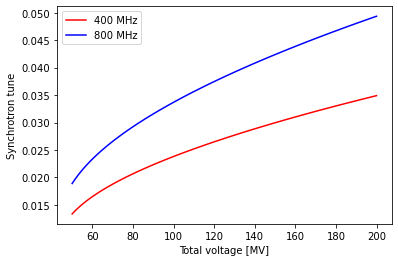

In [4]:
plt.plot(voltage*1e-6, tab_Qs_400, "r-", label="400 MHz")
plt.plot(voltage*1e-6, tab_Qs_800, "b-", label="800 MHz")
plt.xlabel("Total voltage [MV]")
plt.ylabel("Synchrotron tune")
plt.legend()
plt.show()    

In [223]:
tab_dpmax_400

array([0.00536723, 0.00597925, 0.00656146, 0.00711806, 0.00765228,
       0.00816667, 0.00866332, 0.00914393, 0.00960994, 0.01006257,
       0.0105029 , 0.01093182, 0.01135016, 0.01175861, 0.01215783,
       0.01254837, 0.01293075, 0.01330543, 0.01367283, 0.01403333,
       0.01438729, 0.01473503, 0.01507684, 0.01541299, 0.01574374,
       0.01606933, 0.01638998, 0.01670588, 0.01701723, 0.01732421,
       0.01762698, 0.0179257 , 0.01822052, 0.01851158, 0.018799  ,
       0.01908292, 0.01936345, 0.0196407 , 0.01991477, 0.02018577,
       0.02045379, 0.02071892, 0.02098124, 0.02124084, 0.0214978 ,
       0.02175218, 0.02200407, 0.02225352, 0.02250061, 0.02274539,
       0.02298793, 0.02322828, 0.0234665 , 0.02370263, 0.02393674,
       0.02416886, 0.02439905, 0.02462735, 0.0248538 , 0.02507845,
       0.02530133, 0.02552249, 0.02574196, 0.02595977, 0.02617597,
       0.02639059, 0.02660365, 0.02681519, 0.02702525, 0.02723384,
       0.027441  , 0.02764676, 0.02785115, 0.02805418, 0.02825

In [357]:
dpmax = np.linspace(1e-3, 3e-3, 200)
# sigma_z = np.linspace(0.004, 0.015, 200)
V400 = Vt(mode=None, 
          sigma_z=17e-3, 
          alpha=7.32686686e-6*2, 
          Etot=45.6e9, 
          freq=400e+6, 
          dpmax = dpmax)
V800 = Vt(mode=None, 
          sigma_z=15e-3, 
          alpha=7.32686686e-6*2, 
          Etot=45.6e9, 
          freq=800e+6, 
          dpmax = dpmax)

plt.plot(voltage*1e-6, tab_dpmax_400*100, "r-", label="Antoine - 400 MHz", alpha=0.4)
# plt.plot(voltage*1e-6, tab_dpmax_800*100, "b-", label="Antoine - 800 MHz", alpha=0.4)
plt.plot(V400.V_(), dpmax*1000, linestyle='dotted', label='inv budget 400 MHz')
# plt.plot(V800.V_(), dpmax*1000, linestyle='dotted', color='red', label='inv budget 800 MHz')
plt.xlabel("Total voltage [MV]")
plt.ylabel("Momentum acceptance [\%]")
plt.legend()
plt.show()    

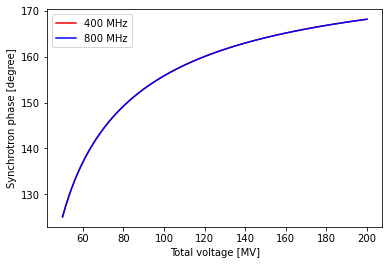

In [7]:
plt.plot(voltage*1e-6, tab_phis_400*180/np.pi, "r-", label="400 MHz")
plt.plot(voltage*1e-6, tab_phis_800*180/np.pi, "b-", label="800 MHz")
plt.xlabel("Total voltage [MV]")
plt.ylabel("Synchrotron phase [degree]")
plt.legend()
plt.show()

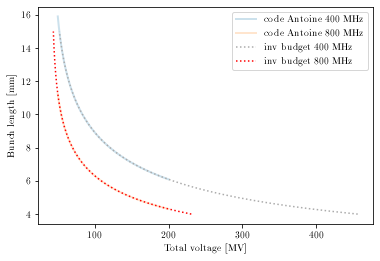

In [332]:
sigma_z = tab_sigz_400*injDRing_400.lambdaRF/2/np.pi
sigma_z = np.linspace(0.004, 0.015, 200)
V400 = Vt(mode=None, 
          sigma_z=sigma_z, 
          alpha=7.32686686e-6*2, 
          Etot=45.6e9, 
          freq=400e+6, 
          dpmax = 1e-3)
V800 = Vt(mode=None, 
          sigma_z=sigma_z, 
          alpha=7.32686686e-6*2, 
          Etot=45.6e9, 
          freq=800e+6, 
          dpmax = 1e-3)
plt.plot(voltage*1e-6, tab_sigz_400*injDRing_400.lambdaRF/2/np.pi*1e3, "-", label="code Antoine 400 MHz", alpha=0.2, linewidth=2)
plt.plot(voltage*1e-6, tab_sigz_800*injDRing_800.lambdaRF/2/np.pi*1e3, "-", label="code Antoine 800 MHz", alpha=0.2, linewidth=2)
plt.plot(V400.V_(), sigma_z*1e3, linestyle='dotted', label='inv budget 400 MHz')
plt.plot(V800.V_(), sigma_z*1e3, linestyle='dotted', color='red', label='inv budget 800 MHz')
plt.xlabel("Total voltage [MV]")
plt.ylabel("Bunch length [mm]")
plt.legend()
plt.show()

In [309]:
sigma_z

array([0.01590615, 0.01524676, 0.01469014, 0.0142099 , 0.0137885 ,
       0.01341373, 0.01307677, 0.01277104, 0.01249151, 0.01223429,
       0.01199624, 0.01177486, 0.01156809, 0.01137423, 0.01119185,
       0.01101975, 0.0108569 , 0.01070243, 0.01055556, 0.01041563,
       0.01028206, 0.01015434, 0.01003201, 0.00991466, 0.00980195,
       0.00969354, 0.00958915, 0.00948851, 0.00939137, 0.00929754,
       0.0092068 , 0.00911898, 0.00903392, 0.00895145, 0.00887144,
       0.00879377, 0.00871831, 0.00864495, 0.00857359, 0.00850413,
       0.00843649, 0.00837058, 0.00830632, 0.00824365, 0.00818248,
       0.00812277, 0.00806445, 0.00800747, 0.00795176, 0.00789729,
       0.00784399, 0.00779184, 0.00774078, 0.00769079, 0.00764181,
       0.00759381, 0.00754676, 0.00750063, 0.00745538, 0.00741099,
       0.00736743, 0.00732467, 0.00728269, 0.00724145, 0.00720095,
       0.00716116, 0.00712205, 0.0070836 , 0.0070458 , 0.00700863,
       0.00697207, 0.00693609, 0.0069007 , 0.00686586, 0.00683

In [284]:
sigma_z = tab_sigz_400*injDRing_400.lambdaRF/2/np.pi
print(sigma_z)
V400 = Vt(mode=None, 
          sigma_z=sigma_z, 
          alpha=7.32686686e-6*2, 
          Etot=45.6e9, 
          freq=400e+6, 
          dpmax = 1e-3)
V400.V_()

[0.01590615 0.01524676 0.01469014 0.0142099  0.0137885  0.01341373
 0.01307677 0.01277104 0.01249151 0.01223429 0.01199624 0.01177486
 0.01156809 0.01137423 0.01119185 0.01101975 0.0108569  0.01070243
 0.01055556 0.01041563 0.01028206 0.01015434 0.01003201 0.00991466
 0.00980195 0.00969354 0.00958915 0.00948851 0.00939137 0.00929754
 0.0092068  0.00911898 0.00903392 0.00895145 0.00887144 0.00879377
 0.00871831 0.00864495 0.00857359 0.00850413 0.00843649 0.00837058
 0.00830632 0.00824365 0.00818248 0.00812277 0.00806445 0.00800747
 0.00795176 0.00789729 0.00784399 0.00779184 0.00774078 0.00769079
 0.00764181 0.00759381 0.00754676 0.00750063 0.00745538 0.00741099
 0.00736743 0.00732467 0.00728269 0.00724145 0.00720095 0.00716116
 0.00712205 0.0070836  0.0070458  0.00700863 0.00697207 0.00693609
 0.0069007  0.00686586 0.00683157 0.00679781 0.00676457 0.00673183
 0.00669958 0.00666781 0.0066365  0.00660564 0.00657523 0.00654525
 0.00651569 0.00648654 0.00645779 0.00642943 0.00640146 0.0063

array([ 50. ,  51.5,  53. ,  54.5,  56. ,  57.5,  59. ,  60.5,  62. ,
        63.5,  65. ,  66.5,  68. ,  69.5,  71. ,  72.5,  74. ,  75.5,
        77. ,  78.5,  80. ,  81.5,  83. ,  84.5,  86. ,  87.5,  89. ,
        90.5,  92. ,  93.5,  95. ,  96.5,  98. ,  99.5, 101. , 102.5,
       104. , 105.5, 107. , 108.5, 110. , 111.5, 113. , 114.5, 116. ,
       117.5, 119. , 120.5, 122. , 123.5, 125. , 126.5, 128. , 129.5,
       131. , 132.5, 134. , 135.5, 137. , 138.5, 140. , 141.5, 143. ,
       144.5, 146. , 147.5, 149. , 150.5, 152. , 153.5, 155. , 156.5,
       158. , 159.5, 161. , 162.5, 164. , 165.5, 167. , 168.5, 170. ,
       171.5, 173. , 174.5, 176. , 177.5, 179. , 180.5, 182. , 183.5,
       185. , 186.5, 188. , 189.5, 191. , 192.5, 194. , 195.5, 197. ,
       198.5, 200. ])

In [114]:
voltage[0]
tab_sigz_400[0]*injDRing_400.lambdaRF/2/np.pi*1e3
tab_dpmax_400[0]

0.005367225369253435

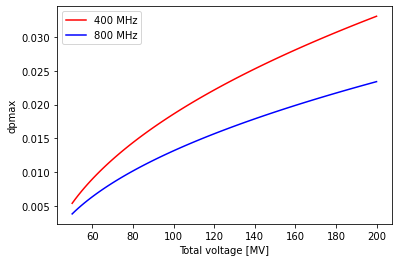

In [84]:
plt.plot(voltage*1e-6, tab_dpmax_400, "r-", label="400 MHz")
plt.plot(voltage*1e-6, tab_dpmax_800, "b-", label="800 MHz")
plt.xlabel("Total voltage [MV]")
plt.ylabel("dpmax")
plt.legend()
plt.show()   

In [19]:
tab_sigz_400*injDRing_400.lambdaRF/2/np.pi*1e3

array([15.90614795, 15.24675636, 14.69013875, 14.20989861, 13.78849924,
       13.41373012, 13.07676674, 12.77103548, 12.49151488, 12.23428687,
       11.99623844, 11.77485709, 11.56808702, 11.37422566, 11.1918478 ,
       11.01974891, 10.85690215, 10.7024253 , 10.55555506, 10.41562666,
       10.28205778, 10.15433552, 10.03200583,  9.91466494,  9.80195218,
        9.69354415,  9.58914975,  9.48850602,  9.39137471,  9.29753922,
        9.20680211,  9.11898291,  9.03391622,  8.95145011,  8.87144468,
        8.79377084,  8.71830923,  8.64494928,  8.57358834,  8.50413096,
        8.43648828,  8.37057734,  8.30632069,  8.24364581,  8.18248478,
        8.12277385,  8.06445313,  8.00746629,  7.95176027,  7.89728505,
        7.8439934 ,  7.79184071,  7.74078476,  7.6907856 ,  7.64180536,
        7.5938081 ,  7.54675972,  7.5006278 ,  7.45538152,  7.41099153,
        7.36742989,  7.32466996,  7.28268632,  7.24145472,  7.20095196,
        7.16115591,  7.12204537,  7.08360005,  7.04580055,  7.00

In [141]:
def dp_vrf(x, *args):
    dpt = args[0]
#     print(dpt)
    f_rf = args[1]
    Cg = 8.846e-5 # m/Gev^3    
    E0 = 45.6 # GeV
    #I2 = 0.000576247850828  # 60°60°
    I1 = 0.669188151989
    I2 = 0.00060404 # 0.000604079202376
    C = 91174.1174166
    I1alpha_c = I1/C
#     print(I1alpha_c)
    alpha_c = 7.32686686e-6*2.
    U0 = Cg*E0**4*I2/2/math.pi*1e9

#     print("U0 = {}".format(U0))
    P0 = 45.6e9
    #Vrf = 60e6
    #f_rf = 400e6
    frev = cons.c/C
    h = f_rf/frev
    # synchronous phase vs vrf
    phis = math.pi/2. - np.arccos(U0/x)
    # synchrotron tune vs Vrf
    Qs = np.sqrt(x/P0*(np.cos(phis)*alpha_c*h)/2/math.pi)
#     print('syn  tune= {}'.format(Qs))
    # momentum acceptance vs Vrf
    return (2*Qs/(h*alpha_c))*np.sqrt((1+(phis-math.pi/2.)*np.tan(phis))) - dpt

In [151]:
# Babara's code for RF voltage calculation
import scipy.constants as cons
from scipy.optimize import fsolve
import math
# other parameters
# C = tw.circumference # circumference [m]
C = 91174.1174166 # circumference [m]
frev = cons.c / C # revolution frequency
f_rf = 800e+6 # [MHz] RF frequency
Harmonic_Num = f_rf / frev
# target momentum acceptance (arg 0)
dptar = 0.017994263797903275
# RF voltage
RF_Voltage = fsolve(dp_vrf, 80e6, (dptar, f_rf))[0]
RF_Voltage*1e-6

135.42266018465412

In [146]:
RF_Voltage*1e-6

135.42266018465418

In [20]:
# constants
Cgamma = 9.846e-5 # m/eV3
freq = float(400e+6) # RF frequency [V]
Erest = cons.m_e*cons.c**2/cons.e # energy at rest [eV]
alpha = 7.32686686e-6 # momentum compaction factor
length = 91174.1174166  # circumfrence [m]
I2 = 0.00060404 # second synchrotron radiation integral
I6 = 0.
Egain = 0. # energy gain
# Mode dependent constants
# Z
Etot = 45.6e+9 # total energy [eV]
alpha_c = 28.5e-6 # momentum compaction
sigma_dsr = 0.038e-2 # energy spread SR
sigma_dbs = 0.132e-2 # energy spread BS
sigma_zsr = 4.38e-3 # bunch length SR [m]
sigma_bsr = 15.4e-3 # bunch length BS [m]
# WW
Etot = 80e+9 # total energy [eV]
alpha_c = 28.5e-6
sgima_dsr = 0.069e-2 # energy spread SR
sgima_dbs = 0.154e-2 # energy spread BS
sgima_zsr = 3.55e-3 # bunch length SR [m]
sgima_bsr = 8.01e-3 # bunch length BS [m]
# ZH
Etot = 120e+9 # total energy [eV]
alpha_c = 7.33e-6
sgima_dsr = 0.103e-2 # energy spread SR
sgima_dbs = 0.185e-2 # energy spread BS
sgima_zsr = 3.34e-3 # bunch length SR [m]
sgima_bsr = 6e-3 # bunch length BS [m]
# tt
Etot = 182.5e+9 # total energy [eV]
alpha_c = 7.33e-6
sgima_dsr = 0.157e-2 # energy spread SR
sgima_dbs = 0.221e-2 # energy spread BS
sgima_zsr = 1.94e-3 # bunch length SR [m]
sgima_bsr = 2.74e-3 # bunch length BS [m]

In [262]:
def sigma_z(Vtot):
    # constants/inputs
    Cgamma = 9.846e-5 # m/eV3
    freq = float(400e+6) # RF frequency [V]
    Erest = cons.m_e*cons.c**2/cons.e # energy at rest [eV]
    alpha = 7.32686686e-6*2 # momentum compaction factor
    length = 91174.1174166  # circumfrence [m]
    I2 = 0.00060404 # second synchrotron radiation integral
    I6 = 0.
    Egain = 0. # energy gain

    # variables
    Etot = 45.6e9
#     Vtot = 50e+6

    # Calculations

    gammat = 1/np.sqrt(alpha) # transition energy
    gamma = Etot / Erest
    eta = 1/gamma**2-alpha # momentum compaction

    lambdaRF = cons.c/freq # RF wavelength


    beta = np.sqrt(1-1/gamma**2) # normalized velocity
    U0 = Cgamma*(Etot*1e-9)**4/2/np.pi*I2*1e9 # Synchrotron energy loss per turn
    phis = np.arcsin((Egain+U0)/Vtot) # synchronus phase - not delta(E)/e*V ?
    if gamma > gammat:
        phis = np.pi-phis
    else:
        phis = phis
        Egain = Vtot*phis-U0
    gradient = Vtot/length # accelerating gradient
    fac = 2*beta**3*Etot*lambdaRF/np.pi/eta
    dEmax = np.sqrt((np.cos(phis)-(np.pi/2-phis)*np.sin(phis))*fac*gradient)
    dpmax = dEmax/Etot
    Qs = length/np.pi*np.sqrt(gradient/fac*np.cos(phis)) # synchrotron tune  
    dppmax = 1e-3
    dpmax = dppmax
    return np.sqrt(2*np.pi*eta/lambdaRF/beta**3/gradient/np.cos(phis)*dpmax**2*Etot)*lambdaRF/2/np.pi*1e3 # bunch length

In [231]:
# def sigma_z(Vtot):
# constants/inputs
Cgamma = 9.846e-5 # m/eV3
freq = float(800e+6) # RF frequency [V]
Erest = cons.m_e*cons.c**2/cons.e # energy at rest [eV]
alpha = 7.32686686e-6*2 # momentum compaction factor
# length = 91174.1174166  # circumfrence [m]
length = 91174.117  # circumfrence [m]
I2 = 0.00060404 # second synchrotron radiation integral
I6 = 0.
Egain = 0. # energy gain

# variables
Etot = 45.6e9
Vtot = 50e+6

# Calculations

gammat = 1/np.sqrt(alpha) # transition energy
gamma = Etot / Erest
eta = 1/gamma**2-alpha # momentum compaction

lambdaRF = cons.c/freq # RF wavelength


beta = np.sqrt(1-1/gamma**2) # normalized velocity
U0 = Cgamma*(Etot*1e-9)**4/2/np.pi*I2*1e9 # Synchrotron energy loss per turn
phis = np.arcsin((Egain+U0)/Vtot) # synchronus phase - not delta(E)/e*V ?
if gamma > gammat:
    phis = np.pi-phis
else:
    phis = phis
    Egain = Vtot*phis-U0
gradient = Vtot/length # accelerating gradient
fac = 2*beta**3*Etot*lambdaRF/np.pi/eta
dEmax = np.sqrt((np.cos(phis)-(np.pi/2-phis)*np.sin(phis))*fac*gradient)
dpmax = dEmax/Etot
Qs = length/np.pi*np.sqrt(gradient/fac*np.cos(phis)) # synchrotron tune  
dppmax = 1e-3
dpmax = dppmax
sigma_z = np.sqrt(2*np.pi*eta/lambdaRF/beta**3/gradient/np.cos(phis)*dpmax**2*Etot)*lambdaRF/2/np.pi # bunch length
print('sigma_z = ', sigma_z)
Vt = np.sqrt( (lambdaRF*eta*dpmax**2*Etot*length/sigma_z**2/2/np.pi/beta**3)**2 + (Egain + U0)**2 )*1e-6
print('Vt = ', np.round(Vt,2))

sigma_z =  0.01124734507885943
Vt =  50.0


In [4]:
class Vt:
    'Calculate total Vtot'
    # initialization or constructor method of
    _defaults_={
        'Cgamma' : 9.846e-5, # m/eV3
        'Erest' : cons.m_e*cons.c**2/cons.e, # energy at rest [eV]
#         'alpha' : 7.32686686e-6, # momentum compaction factor
        'length' : 91174.1174166,  # circumfrence [m]
        'I2' : 0.00060404, # second synchrotron radiation integral
        'I6' : 0.,
        'Egain' : 0.,#24*1e+6,# pour 80 GeV/s, # energy gain
        'sigma_e' : 0.4e-3 # maximum energy spread
    }
    def __init__(self, mode, freq, **kw):
        kw_loc = dict(Vt._defaults_)
        kw_loc.update(kw)
        for key, val in kw_loc.items():
            setattr(self, key, val)
        self.set_mode(mode)
        self.set_freq(freq)
        self.set_alpha()
        self.V_()
        self.dp_()

    def set_mode(self, mode=None, alpha=None, Etot=None, sigma_z=None):
        if alpha is not None:
            self.alpha = alpha
        if Etot is not None:
            self.Etot = Etot
        if sigma_z is not None:
            self.sigma_z = sigma_z
        if mode is not None:
            self.mode = mode
            if self.mode=='inj':#at injection
                self.Etot = 20e+9 # total energy [eV]
                self.sigma_z = 3e-3 # bunch length SR [m]
                self.alpha = 1.49e-5 # momentum compaction factor
            if self.mode == 'z': # z
                self.Etot = 45.6e+9 # total energy [eV]
                self.sigma_z = 4.38e-3 # bunch length SR [m]
                self.alpha = 1.49e-5 # momentum compaction factor
            elif self.mode == 'ww':# WW
                self.Etot = 80e+9 # total energy [eV]
                self.sigma_z = 3.55e-3 # bunch length SR [m]
                self.alpha = 1.49e-5 # momentum compaction factor
            elif self.mode == 'zh':# ZH
                self.Etot = 120e+9 # total energy [eV]
                self.sigma_z = 3.34e-3 # bunch length SR [m]
                self.alpha = 7.34e-6 # momentum compaction factor
            elif self.mode == 'tt':# tt
                self.Etot = 182.5e+9 # total energy [eV]
                self.sigma_z = 1.94e-3 # bunch length SR [m]
                self.alpha = 7.34e-6 # momentum compaction factor
            
    def set_freq(self, freq=None):
        if freq is not None:
            self.freq = freq
        self.lambdaRF = cons.c/self.freq # RF wavelength
        self.frev = cons.c/self.length
        self.h = self.freq/self.frev

    def set_alpha(self, alpha=None):
        if alpha is not None:
            self.alpha = alpha
        self.gammat = 1/np.sqrt(self.alpha) # transition energy
        self.gamma = self.Etot / self.Erest
        self.eta = 1/self.gamma**2-self.alpha # momentum compaction
        self.beta = np.sqrt(1-1/self.gamma**2) # normalized velocity
            
    def V_(self, sigma_e=None, sigma_z=None, Vt=None):
        if sigma_z is not None:
            self.sigma_z = sigma_z
        if sigma_e is not None:
            self.sigma_e = sigma_e
        self.U0 = self.Cgamma*(self.Etot*1e-9)**4/2/np.pi*self.I2*1e9 # Synchrotron energy loss per turn
        self.Vtot = np.sqrt( (self.lambdaRF*self.eta*self.sigma_e**2*self.Etot*self.length/self.sigma_z**2/2/np.pi/self.beta**3)**2 + (self.Egain + self.U0)**2 ) # total voltage in V
#         self.Vtot = 140e+6
#         if Vt is not None:
#             self.Vtot = Vt
#         self.phis = np.arcsin((self.Egain+self.U0)/self.Vtot) # phase synchrone
#         self.gradient = self.Vtot/self.length # accelerating gradient
#         if self.gamma > self.gammat:
#             self.phis = np.pi-self.phis
#         else:
#             self.phis = phis
#             self.Egain = self.Vtot*self.phis-self.U0
#         fac = 2*self.beta**3*self.Etot*self.lambdaRF/np.pi/self.eta
#         self.dEmax = np.sqrt((np.cos(self.phis)-(np.pi/2-self.phis)*np.sin(self.phis))*fac*self.gradient)
#         self.dp = self.dEmax/self.Etot
#         self.Qs = self.length/np.pi*np.sqrt(self.gradient/fac*np.cos(self.phis)) # synchrotron tune
#         self.dp = (2*self.Qs/(self.h*self.alpha))*np.sqrt((1+(self.phis-np.pi/2.)*np.tan(self.phis)))
    def dp_(self, Vx=None):
        if Vx is not None:
            self.Vx = Vx
        else:
            self.Vx = self.Vtot
        self.U0 = self.Cgamma*(self.Etot*1e-9)**4/2/np.pi*self.I2*1e9 # Synchrotron energy loss per turn
        self.phis = np.arcsin((self.Egain+self.U0)/self.Vx) # phase synchrone
        self.gradient = self.Vx/self.length # accelerating gradient
        if self.gamma > self.gammat:
            self.phis = np.pi-self.phis
        else:
            self.phis = phis
            self.Egain = self.Vtot*self.phis-self.U0
        fac = 2*self.beta**3*self.Etot*self.lambdaRF/np.pi/self.eta
        self.dEmax = np.sqrt((np.cos(self.phis)-(np.pi/2-self.phis)*np.sin(self.phis))*fac*self.gradient)
        self.dp = self.dEmax/self.Etot
        self.Qs = self.length/np.pi*np.sqrt(self.gradient/fac*np.cos(self.phis)) # synchrotron tune
#         return dp
    #         self.dp = (2*self.Qs/(self.h*self.alpha))*np.sqrt((1+(self.phis-np.pi/2.)*np.tan(self.phis)))

In [6]:
def dp_vrf(x, *args):
    dpt = args[0]
#     print(dpt)
    f_rf = args[1]
    mode = args[2]
    F = Vt(mode=mode, freq=f_rf)
    Cg = F.Cgamma
    E0 = F.Etot
    I2 = F.I2
    C = F.length
    alpha_c = F.alpha
#     U0 = Cg*E0**4*I2/2/math.pi*1e9
    U0 = F.U0
#     print(F.U0)
    frev = cons.c/C
    h = f_rf/frev
    # synchronous phase vs vrf
    phis = math.pi/2. - np.arccos(U0/x)
    # synchrotron tune vs Vrf
    Qs = np.sqrt(x/E0*(np.cos(phis)*alpha_c*h)/2/math.pi)
#     print('syn  tune= {}'.format(Qs))
    # momentum acceptance vs Vrf
    return (2*Qs/(h*alpha_c))*np.sqrt((1+(phis-math.pi/2.)*np.tan(phis))) - dpt

In [8]:
# Babara's code for RF voltage calculation
import scipy.constants as cons
from scipy.optimize import fsolve
import math
# other parameters
f_rf = 800e+6 # [MHz] RF frequency
dptar = 0.017994263797903275 # target momentum acceptance (arg 0)
mode = 'inj'
Vtot = Vt(mode=mode, freq=f_rf).Vtot
# RF voltage
RF_Voltage = fsolve(dp_vrf, Vtot, (dptar, f_rf, mode))[0]
RF_Voltage*1e-6

39.22582561249057

In [16]:
f_rf = 800e+6 # [MHz] RF frequency
dptar = 0.016387761082908413 # target momentum acceptance (arg 0)
mode = 'z'
Vtot = Vt(mode=mode, freq=f_rf).Vtot
# RF voltage
RF_Voltage = fsolve(dp_vrf, Vtot, (dptar, f_rf, mode))[0]
print(RF_Voltage*1e-6)
print(Vtot*1e-6)

127.38967718256734
51.22944551263154


In [4]:
Vx(sigma_e=0.4e-3, sigma_z=0.005, Vt=200e+6)

NameError: name 'Vx' is not defined

In [104]:
# find the momentum acceptance for the collider
# input data
Vtot = 120e+6
alpha = 28.5e-6
Etot = 45.6e+9
length = 91174.1174166
U0 = 0.0391e+9
Egain = 0
freq = 400e+6
#
Erest = cons.m_e*cons.c**2/cons.e # energy at rest [eV]
gammat = 1/np.sqrt(alpha)
gamma = Etot / Erest
eta = 1/gamma**2-alpha # momentum compaction
beta = np.sqrt(1-1/gamma**2)
frev = cons.c/length
h = freq/frev
gradient = Vtot/length # accelerating gradient
lambdaRF = cons.c/freq
phis = np.arcsin((Egain+U0)/Vtot) # phase synchrone
if gamma > gammat:
    phis = np.pi-phis
else:
    phis = phis
    Egain = Vtot*phis-U0
    
fac = 2*beta**3*Etot*lambdaRF/np.pi/eta
Qs = length/np.pi*np.sqrt(gradient/fac*np.cos(phis)) # synchrotron tune
dp = (2*Qs/(h*alpha))*np.sqrt((1+(phis-np.pi/2.)*np.tan(phis)))
# dp =0.016179660449361876 pour freq = 400MHz, Vtot = 120MV
dp

0.016179660449361876

In [89]:
120/5.75 * 56

1168.695652173913

In [7]:
Vt(mode='z', freq=400e+6).Vtot

73978910.94560897

In [61]:
from astropy.table import QTable, Table, Column
from astropy import units as u

t = QTable()
t = Table(names=('Mode', 'Energy', 'alpha', 'Bunch_length', 'Frequency', 'Voltage_budget', 'U0', 'dp'), 
          dtype=('S2', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4'), 
          units=(None, u.GeV, None, u.mm, u.MHz, u.MV, u.MeV, None)
         )
for mode in ['z', 'ww', 'zh', 'tt']:
    for freq in [400e+6, 800e+6]:
        V = Vt(mode=mode, freq=freq)
        Vbis = V.V_()
        sigma_z = V.sigma_z
        Etot = V.Etot
        U0 = V.U0
        alpha = V.alpha
        dp = V.dp
        t.add_row((mode, Etot*1e-9, alpha, sigma_z, freq*1e-6, Vbis, U0*1e-6, dp))

In [63]:
t.meta['Cgamma [m/eV3]'] = V.Cgamma
t.meta['Erest [eV]'] = V.Erest
t.meta['length [m]'] = V.length
t.meta['I2'] = V.I2
t.meta['I6'] = V.I6
t.meta['Egain'] = V.Egain
t.meta['dpmax'] = V.sigma_e

In [10]:
from astropy.io import ascii
ascii.write(t, 'V_budget_booster_20230228.ecsv', format='ecsv', overwrite=True)

In [64]:
t

<Table length=8>
 Mode   Energy  alpha   Bunch_length ... Voltage_budget     U0          dp     
         GeV                 mm      ...       MV          MeV                 
bytes2 float32 float32    float32    ...    float32      float32     float32   
------ ------- -------- ------------ ... -------------- --------- -------------
     z    45.6 1.49e-05      0.00438 ...            nan  40.92654   0.012818167
     z    45.6 1.49e-05      0.00438 ...            nan  40.92654   0.004117121
    ww    80.0 1.49e-05      0.00355 ...            nan 387.70877  0.0062643136
    ww    80.0 1.49e-05      0.00355 ...            nan 387.70877  0.0016253392
    zh   120.0 7.34e-06      0.00334 ...            nan 1962.7756  0.0011529532
    zh   120.0 7.34e-06      0.00334 ...            nan 1962.7756 0.00028855546
    tt   182.5 7.34e-06      0.00194 ...            nan 10500.189  0.0016733474
    tt   182.5 7.34e-06      0.00194 ...            nan 10500.189 0.00041866384

In [31]:
# collider verification
freq = 399.994581e+6
sigma_z = 3.55e-3
C = 91.1741117e+3
E = 80e+9
alpha = 28.5e-6
dpmax = 0.038e-2
Vc = Vt(mode=None, sigma_z=sigma_z, freq=freq, 
        Etot=E, alpha=alpha)
print(Vc.V_())
# 113.3438177380048 MV au lieu de 120 MV à 45.6 GeV
# 1.0071951950212224 GV au lieu de 1 GV à 80 GeV

1007.1951950212224


(0.0, 12000.0)

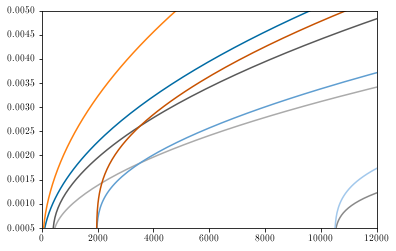

In [22]:
# t = Table(names=('mode','dpmax', 'frequency', 'voltage'), 
#           dtype=('S2', 'f4', 'f4', 'f4'))
t = Table()
from astropy.table import vstack
for mode in ['z', 'ww', 'zh', 'tt']:
    for freq in [400e+6, 800e+6]:
        t_ = Table()
        t_['dpmax'] = np.linspace(1e-5, 1e-2, 200)
        t_['mode'] = mode
        t_['frequency'] = freq
        V = Vt(mode=mode, freq=freq, dpmax=t_['dpmax'])
        t_['voltage'] = V.V_()
        plt.plot(t_['voltage'], 
                 t_['dpmax'], 
                 label = 'mode = '+mode+' | nu = '+str(freq*1e-6)+ ' MHz')
        t = vstack([t, t_])
plt.ylim(5e-4,5e-3)
plt.xlim(0,12000)
# plt.axhline(y=1e-3)
# plt.axvline(x=387.33752)
# plt.axvline(x=10677.072)
# plt.legend()

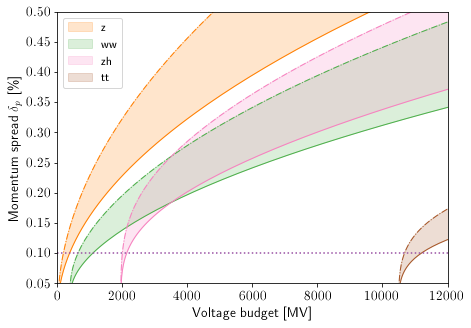

In [27]:
# publication and coloblindness friendly plot
nice_fonts = {
    "text.usetex": True}#,
#     "font.family": "serif",
#     "font.serif" : "Times New Roman",
# }
import matplotlib.style as style
import matplotlib
style.use('tableau-colorblind10')
matplotlib.rcParams.update(nice_fonts)
%config InlineBackend.figure_format = 'png'
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
i = 1
for mode in ['z', 'ww', 'zh', 'tt']:
    t_bis = t[t['mode']==mode]
    t_bis_400 = t_bis[t_bis['frequency']==400e+6]
    t_bis_700 = t_bis[t_bis['frequency']==700e+6]
    t_bis_800 = t_bis[t_bis['frequency']==800e+6]
    ax.plot(t_bis_400['voltage'],t_bis_400['dpmax']*1e+2, 
             linewidth=1, color=CB_color_cycle[i])
    ax.plot(t_bis_800['voltage'],t_bis_800['dpmax']*1e+2, 
             '-.', linewidth=1, color=CB_color_cycle[i])
    ax.fill_betweenx(t_bis_400['dpmax']*1e+2, 
                      t_bis_400['voltage'], 
                      t_bis_800['voltage'], 
                      alpha=0.2, color=CB_color_cycle[i],
                      label=mode)
    i = i + 1
ax.axhline(y=0.1, linestyle='dotted', color=CB_color_cycle[i])
ax.set_ylim(0.05,0.5)
ax.set_xlim(0,12000)
ax.set_xlabel('Voltage budget [MV]', fontsize=14)
ax.set_ylabel('Momentum spread $\delta_p$ [\%]', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)
# plt.savefig('cma_cool_down.pdf', format='pdf', dpi=1000)
ax.legend(fontsize=12);

In [79]:
t

<Table length=8>
 Mode   Energy  alpha   Bunch_length Frequency Voltage_budget     U0   
         GeV                 mm         MHz          MV          MeV   
bytes2 float32 float32    float32     float32     float32      float32 
------ ------- -------- ------------ --------- -------------- ---------
     z    45.6 1.49e-05      0.00438     400.0      387.33752  40.92654
     z    45.6 1.49e-05      0.00438     800.0      196.88531  40.92654
    ww    80.0 1.49e-05      0.00355     400.0      1099.2971 387.70877
    ww    80.0 1.49e-05      0.00355     800.0      644.09015 387.70877
    zh   120.0 7.34e-06      0.00334     400.0        2142.39 1962.7756
    zh   120.0 7.34e-06      0.00334     800.0       2009.185 1962.7756
    tt   182.5 7.34e-06      0.00194     400.0      11190.958 10500.189
    tt   182.5 7.34e-06      0.00194     800.0      10677.072 10500.189

In [238]:
# freq = 400e+6
# Vtot = 384e+6
# Etot = 45e+9
# alpha = 7.32686686e-6 # momentum compaction factor
# def dpmax(Vtot, alpha=None, freq=None, phis=None, Egain=None):
def dp_(freq=freq, Vtot=Vtot, alpha=alpha, Etot=Etot):
    Cgamma = 9.846e-5 # m/eV3
    Erest = cons.m_e*cons.c**2/cons.e # energy at rest [eV]
    length = 91174.1174166  # circumfrence [m]
    I2 = 0.00060404 # second synchrotron radiation integral
    I6 = 0.
    Egain = 0.#24*1e+6,# pour 80 GeV/s, # energy gain
    lambdaRF = cons.c/freq # RF wavelength
    U0 = Cgamma*(Etot*1e-9)**4/2/np.pi*I2*1e9 # Synchrotron energy loss per turn
    gammat = 1/np.sqrt(alpha) # transition energy
    gamma = Etot / Erest
    eta = 1/gamma**2 - alpha # momentum compaction
    beta = np.sqrt(1-1/gamma**2) # normalized velocity
    phis = np.arcsin((Egain+U0)/Vtot) # synchronus phase
    if gamma > gammat:
        phis = np.pi - phis
    else:
        phis = phis
        Egain = Vtot * phis - U0
    gradient = Vtot / length # accelerating gradient
    fac = 2*beta**3*Etot*lambdaRF/np.pi/eta
    dEmax = np.sqrt((np.cos(phis)-(np.pi/2-phis)*np.sin(phis))*fac*gradient)
    dpmax = dEmax/Etot
    Qs = length/np.pi*np.sqrt(gradient/fac*np.cos(phis)) # synchrotron tune
    return dpmax#, Qs, np.cos(phis)

In [237]:
dp_(freq=freq, Vtot=Vtot, alpha=alpha, Etot=Etot)

[5.33314851e-29 2.49260128e-29 1.62636502e-29 1.20692932e-29
 9.59481352e-30 7.96235050e-30 6.80461267e-30 5.94080991e-30
 5.27161195e-30 4.73791334e-30 4.30234358e-30 3.94011744e-30
 3.63414849e-30 3.37227520e-30 3.14560584e-30 2.94748873e-30
 2.77284868e-30 2.61774604e-30 2.47907593e-30 2.35435828e-30
 2.24158820e-30 2.13912734e-30 2.04562382e-30 1.95995224e-30
 1.88116813e-30 1.80847303e-30 1.74118729e-30 1.67872879e-30
 1.62059604e-30 1.56635470e-30 1.51562668e-30 1.46808135e-30
 1.42342829e-30 1.38141138e-30 1.34180386e-30 1.30440428e-30
 1.26903301e-30 1.23552940e-30 1.20374935e-30 1.17356317e-30
 1.14485391e-30 1.11751575e-30 1.09145277e-30 1.06657777e-30
 1.04281135e-30 1.02008101e-30 9.98320448e-31 9.77468893e-31
 9.57470556e-31 9.38274116e-31]


/tmp/ipykernel_25725/3874581085.py:26: RuntimeWarning: invalid value encountered in sqrt
  beta = np.sqrt(1-1/gamma**2) # normalized velocity


array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

/tmp/ipykernel_25725/956911928.py:27: RuntimeWarning: invalid value encountered in arcsin
  phis = np.arcsin((Egain+U0)/Vtot) # synchronus phase


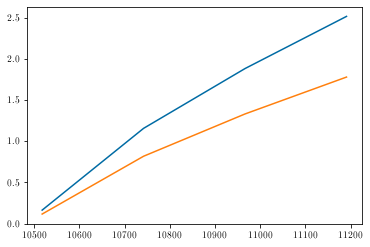

In [239]:
min_v = min(t['Voltage_budget'])
max_v = max(t['Voltage_budget'])
Vtot = np.linspace(min_v, max_v)
# freq = 400e+6
# Etot = 45e+9
# alpha = 7.32686686e-6 # momentum compaction factor
dpm1 = dp_(freq=400e+6, Vtot=Vtot*1e6, alpha=alpha, Etot=Etot*1e9)
dpm2 = dp_(freq=800e+6, Vtot=Vtot*1e6, alpha=alpha, Etot=Etot*1e9)
plt.plot(Vtot, dpm1*100)
plt.plot(Vtot, dpm2*100)

In [246]:
t_bis

<Table length=0>
 Mode   Energy  alpha  Bunch_length ...    U0    dpmax     Qs   cos_phis
         GeV                mm      ...   MeV                           
bytes2 float32 float32   float32    ... float32 float64 float64 float64 
------ ------- ------- ------------ ... ------- ------- ------- --------

/tmp/ipykernel_25725/956911928.py:27: RuntimeWarning: invalid value encountered in arcsin
  phis = np.arcsin((Egain+U0)/Vtot) # synchronus phase
/tmp/ipykernel_25725/956911928.py:27: RuntimeWarning: invalid value encountered in arcsin
  phis = np.arcsin((Egain+U0)/Vtot) # synchronus phase
/tmp/ipykernel_25725/956911928.py:27: RuntimeWarning: invalid value encountered in arcsin
  phis = np.arcsin((Egain+U0)/Vtot) # synchronus phase
/tmp/ipykernel_25725/956911928.py:27: RuntimeWarning: invalid value encountered in arcsin
  phis = np.arcsin((Egain+U0)/Vtot) # synchronus phase
/tmp/ipykernel_25725/956911928.py:27: RuntimeWarning: invalid value encountered in arcsin
  phis = np.arcsin((Egain+U0)/Vtot) # synchronus phase
/tmp/ipykernel_25725/956911928.py:27: RuntimeWarning: invalid value encountered in arcsin
  phis = np.arcsin((Egain+U0)/Vtot) # synchronus phase


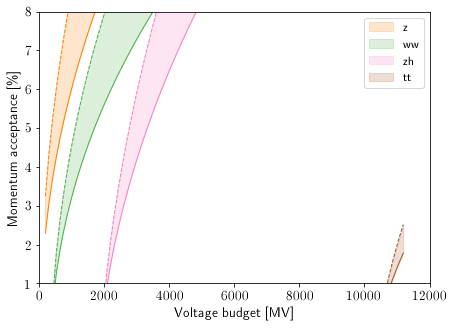

In [272]:
style.use('tableau-colorblind10')
matplotlib.rcParams.update(nice_fonts)
%config InlineBackend.figure_format = 'png'
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
i = 1
min_v = min(t['Voltage_budget'])
max_v = max(t['Voltage_budget'])
Vtot = np.linspace(min_v, max_v, 100)

for mode in ['z', 'ww', 'zh', 'tt']:
    t_bis = t[t['Mode']==mode]
    freq = 400
    t_bis400 = t_bis[t_bis['Frequency']==freq]
    Etot = t_bis400['Energy']
    alpha = t_bis400['alpha']
    dpm400 = dp_(freq=freq*1e6, Vtot=Vtot*1e+6, alpha=alpha, Etot=Etot*1e+9)
    ax.plot(Vtot, dpm400*1e+2, 
            linewidth=1, linestyle='dashed', color=CB_color_cycle[i])
    freq = 800
    t_bis800 = t_bis[t_bis['Frequency']==freq]
    Etot = t_bis800['Energy']
    alpha = t_bis800['alpha']
    dpm800 = dp_(freq=freq*1e6, Vtot=Vtot*1e+6, alpha=alpha, Etot=Etot*1e+9)
    ax.plot(Vtot, dpm800*1e+2, 
            linewidth=1, color=CB_color_cycle[i])
    ax.fill_between(Vtot, dpm400*1e+2, dpm800*1e+2,  
                      alpha=0.2, color=CB_color_cycle[i],
                      label=mode)
    i = i + 1
# ax.axhline(y=0.1, linestyle='dotted', color=CB_color_cycle[i])
ax.set_ylim(1,8)
ax.set_xlim(0,12000)
ax.set_xlabel('Voltage budget [MV]', fontsize=14)
ax.set_ylabel('Momentum acceptance [\%]', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)
# plt.savefig('cma_cool_down.pdf', format='pdf', dpi=1000)
ax.legend(fontsize=12);

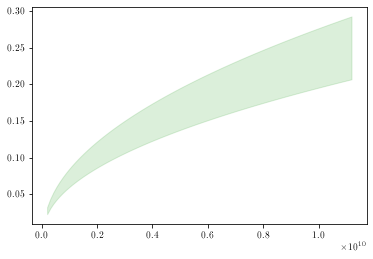

In [265]:
plt.fill_between(Vtot*1e6, dpm400, dpm800,  
                      alpha=0.2, color=CB_color_cycle[i],
                      label=mode)

In [158]:
t['dpmax'] = 0.
t['Qs'] = 0.
t['cos_phis'] = 0.
for row in t:
    freq = row['Frequency']*1e+6
    Vtot = row['Voltage_budget']*1e+6
    Etot = row['Energy']*1e+9
    alpha = row['alpha']
    R = dp_(freq=freq, Vtot=Vtot, alpha=alpha, Etot=Etot)
    row['dpmax'] = R[0]
    row['Qs'] = R[1]
    row['cos_phis'] = R[2]
    del R

In [161]:
t

<Table length=8>
 Mode   Energy  alpha   ...          Qs                cos_phis      
         GeV            ...                                          
bytes2 float32 float32  ...       float64              float64       
------ ------- -------- ... -------------------- --------------------
     z    45.6 1.49e-05 ...  0.04936284740879033  -0.9944021911899491
     z    45.6 1.49e-05 ...  0.04936284802425067  -0.9781564783709524
    ww    80.0 1.49e-05 ...  0.06090436466414423  -0.9357410262181884
    ww    80.0 1.49e-05 ...  0.06090436586807276  -0.7985353112192228
    zh   120.0 7.34e-06 ...  0.03188895372184858 -0.40080884102820746
    zh   120.0 7.34e-06 ...  0.03188895380871663 -0.21369082227648642
    tt   182.5 7.34e-06 ...  0.05490167891016427 -0.34589179608017223
    tt   182.5 7.34e-06 ... 0.054901686857857804  -0.1812698083140179

In [171]:
# number of variable
categories = ['dpmax', 'Qs', 'cos_phis']
N = len(categories)
df = t[categories].to_pandas

In [181]:
list(t[categories][0])

[0.05004905082314101, 0.04936284740879033, -0.9944021911899491]

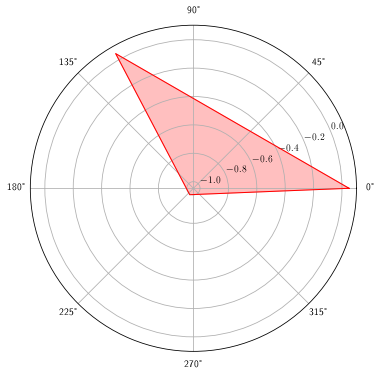

In [184]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
# Each attribute we'll plot in the radar chart.
labels = categories

# Let's look at the 1970 Chevy Impala and plot it.
values = list(t[categories][0])

# Number of variables we're plotting.
num_vars = len(labels)

# Split the circle into even parts and save the angles
# so we know where to put each axis.
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is a circle, so we need to "complete the loop"
# and append the start value to the end.
values += values[:1]
angles += angles[:1]

# ax = plt.subplot(polar=True)
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Draw the outline of our data.
ax.plot(angles, values, color='red', linewidth=1)
# Fill it in.
ax.fill(angles, values, color='red', alpha=0.25)

In [185]:
angles

[0.0, 2.0943951023931953, 4.1887902047863905, 0.0]

<AxesSubplot:xlabel='voltage', ylabel='dpmax'>

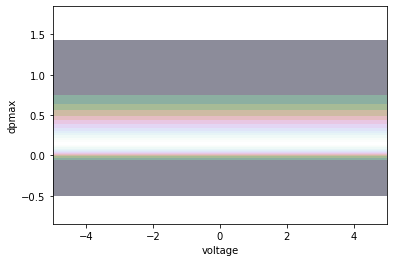

In [104]:
import seaborn as sns
# cmap = sns.cubehelix_palette(start=s, light=1, as_cmap=True)
cmap = 'cubehelix'
sns.kdeplot(
        x='voltage', y='dpmax',
        data=df,# hue='mode',
        cmap=cmap, fill=True,
        clip=(-5, 5), cut=10,
        thresh=0, levels=15, alpha=0.5)

In [ ]:
y = df.dpmax
x = df.voltage
z = df.frequency
plt.imshow(x, y, z, levels=14, linewidths=0.5, colors='k')

In [96]:
from sympy import *
from sympy.solvers import solve
from sympy import Symbol, pi, asin
A = Symbol('A')
z = Symbol('z')
y = Symbol('y')
eq = y*(asin(y))
# eq =(A + pi/2*y*z-y*z*asin(y))**2-1+y**2
# solve(eq, y)
expand(eq)

y*asin(y)